In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

### 读取原始数据

In [2]:
df = pd.read_csv("Tianchi_power.csv")
df['record_date'] = pd.to_datetime(df['record_date'])
df.head()


,record_date,user_id,power_consumption
0,2015-01-01,1,1135
1,2015-01-02,1,570
2,2015-01-03,1,3418
3,2015-01-04,1,3968
4,2015-01-05,1,3986


### 填充缺省值

In [3]:
dates = pd.date_range("2015-01-01","2016-08-31", freq="1D")
userid = pd.DataFrame({'user_id':df['user_id'].unique()})
dates = pd.DataFrame(dates)
dates.columns = ['record_date']
userid['key'] = 0
dates['key'] = 0
full = userid.merge(dates, how='left', on = 'key')
full.drop('key',1, inplace=True)
full.head(2)

,user_id,record_date
0,1,2015-01-01
1,1,2015-01-02


In [4]:
df = pd.merge(full, df, how='left', on=['user_id','record_date'])
df['power_consumption'] = df['power_consumption'].interpolate()
df.shape

(885486, 3)

### 填充特征

In [5]:
df['dow'] = df['record_date'].apply(lambda x: x.dayofweek)
df['doy'] = df['record_date'].apply(lambda x: x.dayofyear)
df['day'] = df['record_date'].apply(lambda x: x.day)
df['month'] = df['record_date'].apply(lambda x: x.month)
df['year'] = df['record_date'].apply(lambda x: x.year)

def map_season(month):
    month_dic = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:3, 9:3, 10:4, 11:4, 12:1}
    return month_dic[month]

df['season'] = df['month'].apply(lambda x: map_season(x))

In [6]:
### 用电量聚合到一个月

base_df = df[['record_date','power_consumption']].groupby(by='record_date').agg('sum')
base_df = base_df.reset_index()
base_df.head()
base_df.shape
# df = base_df

(609, 2)

### 拼接测试集

In [7]:
df_test = base_df[(base_df.record_date>='2016-08-01')&(base_df.record_date<='2016-08-30')]
df_test['record_date'] = pd.DataFrame(df_test['record_date']+pd.Timedelta('31 days'))
df_test.head()

,record_date,power_consumption
578,2016-09-01,4627029.0
579,2016-09-02,4618467.0
580,2016-09-03,4490739.0
581,2016-09-04,4367727.0
582,2016-09-05,4253298.0


In [8]:
df = pd.concat([base_df, df_test]).sort_values(['record_date'])
# base_df.shape

# df = base_df
df.head()


,record_date,power_consumption
0,2015-01-01,2900575.0
1,2015-01-02,3158211.0
2,2015-01-03,3596487.0
3,2015-01-04,3939672.0
4,2015-01-05,4101790.0


In [9]:
base_df = df
df.head()

,record_date,power_consumption
0,2015-01-01,2900575.0
1,2015-01-02,3158211.0
2,2015-01-03,3596487.0
3,2015-01-04,3939672.0
4,2015-01-05,4101790.0


### 造特征

In [10]:
base_df['dow'] = base_df['record_date'].apply(lambda x: x.dayofweek)
base_df['doy'] = base_df['record_date'].apply(lambda x: x.dayofyear)
base_df['day'] = base_df['record_date'].apply(lambda x: x.day)
base_df['month'] = base_df['record_date'].apply(lambda x: x.month)
base_df['year'] = base_df['record_date'].apply(lambda x: x.year)

def map_season(month):
    month_dic = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:3, 9:3, 10:4, 11:4, 12:1}
    return month_dic[month]

# base_df['season'] = base_df['month'].apply(lambda x: map_season(x))

### 添加更多特征
### 先添加前一个月的均值和方差

In [11]:
df_stats = base_df[['power_consumption','year','month']].groupby(by=['year', 'month']).agg(['mean', 'std'])
df_stats.head()

df_stats.columns = df_stats.columns.droplevel(0)
df_stats = df_stats.reset_index()
df_stats.head()
df_stats['mean'] = df_stats['mean'].shift(1)
# df_stats['2_m_mean'] = df_stats['mean'].shift(2)
df_stats['std'] = df_stats['std'].shift(1)
# df_stats['2_m_std'] = df_stats['std'].shift(2)
df_stats.head()


,year,month,mean,std
0,2015,1,NaN,NaN
1,2015,2,3.961383e+06,303629.486622
2,2015,3,2.795163e+06,769697.864999
3,2015,4,3.478852e+06,564753.747993
4,2015,5,3.768333e+06,190787.832757


In [12]:
# train = pd.merge('base_df','df_stats',on=['year','month'])
train = pd.merge(base_df, df_stats, how='left', on=['year','month'])
train.head()

,record_date,power_consumption,dow,doy,day,month,year,mean,std
0,2015-01-01,2900575.0,3,1,1,1,2015,NaN,NaN
1,2015-01-02,3158211.0,4,2,2,1,2015,NaN,NaN
2,2015-01-03,3596487.0,5,3,3,1,2015,NaN,NaN
3,2015-01-04,3939672.0,6,4,4,1,2015,NaN,NaN
4,2015-01-05,4101790.0,0,5,5,1,2015,NaN,NaN


### 把一个月分成上下 半月
### 用它们的均值之差表示数据上下起伏趋势

In [13]:
# 先对一个月做切分
def month_half(day):
    if day>=1 and day<=15:
        return 1
    else:
        return 2

base_df['month_half'] = base_df['day'].apply(lambda x:month_half(x))
# base_df['week_period'] = base_df['day'].apply(lambda x:week_period(x))

half = base_df[['power_consumption','year','month','month_half']].groupby(by=['year', 'month', 'month_half']).agg('mean')
half = half.reset_index()
half.head()

half['month_half'] = half['power_consumption'].diff(1)
month_period_df = half.drop('power_consumption',1)
# half.head()

month_period_df = month_period_df[['year','month','month_half']].groupby(by=['year','month']).agg(lambda x: ",".join(x.apply(str).values.tolist()))
month_period_df = month_period_df.reset_index()
month_period_df[['first_half','second_half']] =  month_period_df['month_half'].str.split(',', expand=True) 
month_period_df = month_period_df.drop('month_half',1)

# month_1_columns = [tmp+'_1month' for tmp in ['month_period_1', 'month_period_2','month_period_3']]
month_period_df[['first_half','second_half']] = month_period_df[['first_half','second_half']].shift(1)
# month_2_columns = [tmp+'_2month' for tmp in ['month_period_1', 'month_period_2','month_period_3']]
# month_period_df[month_2_columns] = month_period_df[['month_period_1', 'month_period_2','month_period_3']].shift(2)

month_period_df.head()




,year,month,first_half,second_half
0,2015,1,NaN,NaN
1,2015,2,nan,156902.8125
2,2015,3,-674272.145833,-1223101.62821
3,2015,4,1219955.32821,230498.695833
4,2015,5,164766.270833,26365.9333333


In [14]:

# 合并
train =  pd.merge(train, month_period_df, how='left', on=['year','month'])
train.head()

,record_date,power_consumption,dow,doy,day,month,year,mean,std,first_half,second_half
0,2015-01-01,2900575.0,3,1,1,1,2015,NaN,NaN,NaN,NaN
1,2015-01-02,3158211.0,4,2,2,1,2015,NaN,NaN,NaN,NaN
2,2015-01-03,3596487.0,5,3,3,1,2015,NaN,NaN,NaN,NaN
3,2015-01-04,3939672.0,6,4,4,1,2015,NaN,NaN,NaN,NaN
4,2015-01-05,4101790.0,0,5,5,1,2015,NaN,NaN,NaN,NaN


### 把一个月分成上中下旬3个month_periods 或者 4周总共4个week_periods
### 用它们的均值之差表示数据上下起伏趋势

In [15]:
# 先对一个月做切分
def month_period(day):
    if day>=1 and day<=10:
        return 1
    elif day>=11 and day<=20:
        return 2
    else:
        return 3

def week_period(day):
    if day>=1 and day<=7:
        return 1
    elif day>=8 and day<=14:
        return 2
    elif day>=15 and day<=21:
        return 3
    else:
        return 4

base_df['month_period'] = base_df['day'].apply(lambda x:month_period(x))
base_df['week_period'] = base_df['day'].apply(lambda x:week_period(x))

### 按照period求均值

In [16]:
month_period_df = base_df[['power_consumption','year','month','month_period']].groupby(by=['year', 'month', 'month_period']).agg('mean')
month_period_df = month_period_df.reset_index()
month_period_df.head()

,year,month,month_period,power_consumption
0,2015,1,1,3.825766e+06
1,2015,1,2,4.016926e+06
2,2015,1,3,4.034177e+06
3,2015,2,1,3.691394e+06
4,2015,2,2,2.338909e+06


### 求出来均值之差

In [17]:
month_period_df['month_period'] = month_period_df['power_consumption'].diff(1)
month_period_df['3sepmean'] = month_period_df['power_consumption']#.diff(1)
month_period_df = month_period_df.drop('power_consumption',1)
month_period_df.head()

mdf = month_period_df

### 填充上个月和上上个月的趋势数据

In [18]:
month_period_df = month_period_df[['year','month','month_period']].groupby(by=['year','month']).agg(lambda x: ",".join(x.apply(str).values.tolist()))
month_period_df = month_period_df.reset_index()
month_period_df[['month_period_1','month_period_2','month_period_3']] =  month_period_df['month_period'].str.split(',', expand=True) 
month_period_df = month_period_df.drop('month_period',1)

# month_1_columns = [tmp+'_1month' for tmp in ['month_period_1', 'month_period_2','month_period_3']]
month_period_df[['month_period_1', 'month_period_2','month_period_3']] = month_period_df[['month_period_1', 'month_period_2','month_period_3']].shift(1)


# 添加每一旬的均值做为特征
mdf = mdf[['year','month','3sepmean']].groupby(by=['year','month']).agg(lambda x: ",".join(x.apply(str).values.tolist()))
mdf = mdf.reset_index()
mdf[['3sepmean_1','3sepmean_2','3sepmean_3']] =  mdf['3sepmean'].str.split(',', expand=True) 
mdf = mdf.drop('3sepmean',1)

# month_1_columns = [tmp+'_1month' for tmp in ['month_period_1', 'month_period_2','month_period_3']]
mdf[['3sepmean_1','3sepmean_2','3sepmean_3']] = mdf[['3sepmean_1','3sepmean_2','3sepmean_3']].shift(1)
# month_2_columns = [tmp+'_2month' for tmp in ['month_period_1', 'month_period_2','month_period_3']]
# month_period_df[month_2_columns] = month_period_df[['month_period_1', 'month_period_2','month_period_3']].shift(2)

mdf.head()

,year,month,3sepmean_1,3sepmean_2,3sepmean_3
0,2015,1,NaN,NaN,NaN
1,2015,2,3825766.2,4016926.2,4034177.45455
2,2015,3,3691394.3,2338908.6,2245192.0625
3,2015,4,3108414.7,3667572.75,3644050.09091
4,2015,5,3753272.1,3727802.35,3823925.45


In [19]:
# 合并
train_mon =  pd.merge(train, month_period_df, how='left', on=['year','month'])
train_mon.head()

# train_mon =  pd.merge(train_mon, mdf, how='left', on=['year','month'])
# train_mon.head()

,record_date,power_consumption,dow,doy,day,month,year,mean,std,first_half,second_half,month_period_1,month_period_2,month_period_3
0,2015-01-01,2900575.0,3,1,1,1,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,3158211.0,4,2,2,1,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,3596487.0,5,3,3,1,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,3939672.0,6,4,4,1,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,4101790.0,0,5,5,1,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
week_period_df = base_df[['power_consumption','year','month','week_period']].groupby(by=['year', 'month', 'week_period']).agg('mean')
week_period_df = week_period_df.reset_index()
# week_period_df.head()

In [21]:
week_period_df['week_period'] = week_period_df['power_consumption'].diff(1)
week_period_df = week_period_df.drop('power_consumption',1)
# week_period_df.head()

In [22]:
# 将每个月中四个周的值分为四列。
week_period_df = week_period_df[['year','month','week_period']].groupby(by=['year','month']).agg(lambda x: ",".join(x.apply(str).values.tolist()))
week_period_df = week_period_df.reset_index()
week_period_df[['week_period_1','week_period_2','week_period_3','week_period_4']] =  week_period_df['week_period'].str.split(',', expand=True) 
week_period_df = week_period_df.drop('week_period',1)

add_columns_1 = [tmp+'_1month' for tmp in ['week_period_1', 'week_period_2','week_period_3', 'week_period_4']]
week_period_df[['week_period_1','week_period_2','week_period_3','week_period_4']] = week_period_df[['week_period_1', 'week_period_2','week_period_3', 'week_period_4']].shift(1)
# add_columns_2 = [tmp+'_2month' for tmp in ['week_period_1', 'week_period_2','week_period_3', 'week_period_4']]
# week_period_df[add_columns_2] = week_period_df[['week_period_1', 'week_period_2','week_period_3', 'week_period_4']].shift(2)

week_period_df.head()



,year,month,week_period_1,week_period_2,week_period_3,week_period_4
0,2015,1,NaN,NaN,NaN,NaN
1,2015,2,nan,297703.428571,46736.2857143,-31404.2714286
2,2015,3,-220744.014286,-739169.857143,-1042483.85714,252348.357143
3,2015,4,645923.071429,821015.214286,-292440.071429,245783.857143
4,2015,5,-9620.85714286,113845.428571,-66743.6428571,91990.9047619


In [23]:
# 添加 week period 相关特征
df_final = pd.merge(train_mon, week_period_df, how='left', on=['year','month']) 

In [24]:
# df_final.head()

In [25]:
df_final.columns

Index([u'record_date', u'power_consumption', u'dow', u'doy', u'day', u'month',
       u'year', u'mean', u'std', u'first_half', u'second_half',
       u'month_period_1', u'month_period_2', u'month_period_3',
       u'week_period_1', u'week_period_2', u'week_period_3', u'week_period_4'],
      dtype='object')

### 去掉不需要的数据

In [26]:
df_final = df_final[df_final.record_date>='2015-03-01']
# df_final['previous_2months_diff'] = df_final['1_m_mean']-df_final['2_m_mean']
df_final.head()

,record_date,power_consumption,dow,doy,day,month,year,mean,std,first_half,second_half,month_period_1,month_period_2,month_period_3,week_period_1,week_period_2,week_period_3,week_period_4
59,2015-03-01,2900464.0,6,60,1,3,2015,2.795163e+06,769697.864999,-674272.145833,-1223101.62821,-342783.154545,-1352485.7,-93716.5375,-220744.014286,-739169.857143,-1042483.85714,252348.357143
60,2015-03-02,3334082.0,0,61,2,3,2015,2.795163e+06,769697.864999,-674272.145833,-1223101.62821,-342783.154545,-1352485.7,-93716.5375,-220744.014286,-739169.857143,-1042483.85714,252348.357143
61,2015-03-03,3492606.0,1,62,3,3,2015,2.795163e+06,769697.864999,-674272.145833,-1223101.62821,-342783.154545,-1352485.7,-93716.5375,-220744.014286,-739169.857143,-1042483.85714,252348.357143
62,2015-03-04,3597890.0,2,63,4,3,2015,2.795163e+06,769697.864999,-674272.145833,-1223101.62821,-342783.154545,-1352485.7,-93716.5375,-220744.014286,-739169.857143,-1042483.85714,252348.357143
63,2015-03-05,1798044.0,3,64,5,3,2015,2.795163e+06,769697.864999,-674272.145833,-1223101.62821,-342783.154545,-1352485.7,-93716.5375,-220744.014286,-739169.857143,-1042483.85714,252348.357143


### 异常值

In [27]:
# df1 = df_final[(df_final.record_date >= '2016-03-01')]#
# df2 = df_final[(df_final.record_date < '2016-01-01')]#
# # df_final = df_final[(df_final.record_date >= '2016-03-01')]#| (df_final.record_date < '2016-01-01')]
# # df_final['previous_2months_diff'] = df_final['1_m_mean']-df_final['2_m_mean']
# df_final = pd.concat([df2,df1])
# df_final.head()

In [28]:
## 
df_final.record_date.unique()

array(['2015-03-01T00:00:00.000000000', '2015-03-02T00:00:00.000000000',
       '2015-03-03T00:00:00.000000000', '2015-03-04T00:00:00.000000000',
       '2015-03-05T00:00:00.000000000', '2015-03-06T00:00:00.000000000',
       '2015-03-07T00:00:00.000000000', '2015-03-08T00:00:00.000000000',
       '2015-03-09T00:00:00.000000000', '2015-03-10T00:00:00.000000000',
       '2015-03-11T00:00:00.000000000', '2015-03-12T00:00:00.000000000',
       '2015-03-13T00:00:00.000000000', '2015-03-14T00:00:00.000000000',
       '2015-03-15T00:00:00.000000000', '2015-03-16T00:00:00.000000000',
       '2015-03-17T00:00:00.000000000', '2015-03-18T00:00:00.000000000',
       '2015-03-19T00:00:00.000000000', '2015-03-20T00:00:00.000000000',
       '2015-03-21T00:00:00.000000000', '2015-03-22T00:00:00.000000000',
       '2015-03-23T00:00:00.000000000', '2015-03-24T00:00:00.000000000',
       '2015-03-25T00:00:00.000000000', '2015-03-26T00:00:00.000000000',
       '2015-03-27T00:00:00.000000000', '2015-03-28

### 保存测试集

In [29]:
df_final = df_final.drop(['record_date'],1)
df_final.to_csv('train.csv', index=False)

In [30]:

# # ### 生成训练集和测试集

# # import pandas as pd
# # df_final = pd.read_csv('train.csv')

# # # df_final = df_final.drop('record_date',1)

# final_train_data = df_final[~((df_final.year==2016)&(df_final.month==9))].drop(['power_consumption'],1)
# final_train_data = final_train_data.astype(float)
# final_test_data = df_final[((df_final.year==2016)&(df_final.month==9))].drop(['power_consumption'],1)
# final_test_data = final_test_data.astype(float)
# train_target = df_final[~((df_final.year==2016)&(df_final.month==9))][['power_consumption']]

# # # train_lgb = final_train_data.copy()
# # # train_lgb[['dow','doy','day','month','year']] = train_lgb[['dow','doy','day','month','year']]\
# # # .astype(str)
# # # test_lgb = final_test_data.copy()
# # # test_lgb[['dow','doy','day','month','year']] = test_lgb[['dow','doy','day','month','year',]]\
# # # .astype(str)

# # # X_lgb = train_lgb.values
# # # y_lgb = train_target.values.reshape(train_target.values.shape[0],)
# # # # print y_lgb[0]
# # # # print X_lgb[0,:]

# # # #随机敲定一组参数跑模型
# # # # import lightgbm as lgb
# # # from sklearn.metrics import mean_squared_error
# # # import matplotlib.pyplot as plt
# # # %matplotlib inline
# # # # create dataset for lightgbm
# # # lgb_train = lgb.Dataset(X_lgb, y_lgb)
# # # # specify your configurations as a dict
# # # params = {
# # #     'num_leaves': 1024,
# # #     'learning_rate':0.42,
# # #     'n_estimators':30,
# # #     'feature_fraction': 1,
# # #     'bagging_fraction': 0.8,
# # #     'bagging_freq': 5
# # # }

# # # print('Start training...')
# # # # train

# # # evals_result = {}  # to record eval results for plotting

# # # gbm = lgb.train(params,
# # #                 lgb_train,
# # #                 num_boost_round=30,
# # #                 feature_name=list(final_train_data.columns))


# # # # gbm = lgb.train(params,
# # # #                 lgb_train,
# # # #                 num_boost_round=30,
# # # # #                 valid_sets=[lgb_train, lgb_test],
# # # #                 feature_name=list(final_train_data.columns)),
# # # # #                 categorical_feature=[21],
# # # #                 evals_result=evals_result,
# # # # #                 verbose_eval=10
# # # #         )
# # # df_final.head()

### 特征重要度排序

In [31]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# print('Plot feature importances...')
# ax = lgb.plot_importance(gbm, max_num_features=10)
# plt.show()


In [32]:
# commit_df = pd.date_range('2016/9/1', periods=30, freq='D')
# commit_df = pd.DataFrame(commit_df)
# commit_df.columns = ['predict_date']
# y_predict = gbm.predict(test_lgb.values)
# commit_df['predict_power_consumption'] = pd.DataFrame(y_predict).astype('int')
# commit_df

In [33]:
# # 生成提交结果文件
# # 转换日期格式 

# from datetime import datetime 

# def timetransform(t):
#     t = str(t)[0:10]
#     time = datetime.strptime(t, '%Y-%m-%d')
#     res = time.strftime('%Y%m%d')
#     return res

# commit_df['predict_date'] = commit_df['predict_date'].apply(timetransform)

# commit_df.head()
# commit_df.to_csv('Tianchi_power_predict_table.csv',index=False)

In [34]:
# # 读入最好的成绩 做参考
# ref = pd.read_csv('predict_ref0529.csv')
# # test_x = pd.read_csv('test.csv')
# # train_y = train['power_consumption']
# # train_X = train.drop('power_consumption',axis=1)
# # train_X.shape
# # ref

In [35]:
# # 读取当前预测结果
# cur = pd.read_csv('Tianchi_power_predict_table.csv')
# # test_x = pd.read_csv('test.csv')
# # train

In [36]:
# y2 = cur['predict_power_consumption'].values
# x = cur['predict_date'].values
# y = ref['predict_power_consumption'].values

# plt.plot(x, y)
# plt.plot(x,y2)
# plt.legend(['ref','cur'],loc = 0, ncol = 2)



In [37]:
# 尝试不同模型

In [38]:
# Stacking

### 模型融合 blending.py 
### stacking

In [39]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import Perceptron
# from sklearn.linear_model import SGDClassifier
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split

In [48]:

# 准备数据

# train = df_final
# x_test = train[train.]
# y = train['power_consumption']
# X = train.drop('power_consumption',axis=1)


final_train_data = df_final[~((df_final.year==2016)&(df_final.month==9))].drop(['power_consumption'],1)
final_train_data = final_train_data.astype(float)
final_test_data = df_final[((df_final.year==2016)&(df_final.month==9))].drop(['power_consumption'],1)
final_test_data = final_test_data.astype(float)
train_target = df_final[~((df_final.year==2016)&(df_final.month==9))][['power_consumption']]

train = final_train_data.copy()
train[['dow','doy','day','month','year']] = train[['dow','doy','day','month','year']]\
.astype(str)
test = final_test_data.copy()
test[['dow','doy','day','month','year']] = test[['dow','doy','day','month','year',]]\
.astype(str)

train = train.values
train_y = train_target.values.reshape(train_target.values.shape[0],) 
# train_target中只有一列数据，.values 按行取出所有值，每一行的数据用一个列表存放，n行数据结成一个元素为列表的列表
# reshape 用于对上面生成的列表做处理，去掉嵌套的列表变量，成为一个元素为数值的列表
test = test.values
# print y_lgb[0]
# print X_lgb[0,:]
# train.dtypes#.shape[0]

train.shape
test.shape
# train.head()

(30, 16)

In [52]:
# train_target.values.reshape(train_target.values.shape[0],)
# train_target.values.shape[0]
# test.values
x_train = train
y_train = train_y
x_test = test

In [53]:
# step 1  

# for ExtraTreesRegressor RandomForestRegressor
from sklearn.model_selection import KFold

ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 10 # set folds for out-of-fold prediction
# kf = KFold(ntrain, n_splits= NFOLDS, random_state=SEED)
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

def kfolds_pre(reg, x_train, y_train, x_test):
    kfolds_train = np.zeros((ntrain,))
    kfolds_test = np.zeros((ntest,))
    kfolds_test_all = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        reg.fit(x_tr, y_tr)

        kfolds_train[test_index] = reg.predict(x_te)
        kfolds_test_all[i, :] = reg.predict(x_test)

    kfolds_test[:] = kfolds_test_all.mean(axis=0)
    return kfolds_train.reshape(-1, 1), kfolds_test.reshape(-1, 1)



In [54]:
# step 2 

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

from __future__ import division
import numpy as np
# import load_data
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# import xgboost as xgb
from sklearn.cross_validation import KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor



# rfr = RandomForestRegressor(n_estimators=100)
# gbr = GradientBoostingRegressor(n_estimators=100)
# etsr = ExtraTreesRegressor(n_estimators=100)
br = BaggingRegressor(n_estimators=1000)
abr = AdaBoostRegressor(n_estimators=100)

rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, criterion='mse')
etsr = ExtraTreesRegressor(n_estimators=100, n_jobs=-1, criterion='mse')


# rfr1 = RandomForestRegressor(n_estimators=100, n_jobs=-1, criterion='mse')
# rfr2 = RandomForestRegressor(n_estimators=100, n_jobs=-1, criterion='mae')
# etsr1 = ExtraTreesRegressor(n_estimators=100, n_jobs=-1, criterion='mse')
# etsr2 = ExtraTreesRegressor(n_estimators=100, n_jobs=-1, criterion='mae')
# gbr = GradientBoostingRegressor(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=50)


# Create train and test predictions. These base results will be used as new features

rfr_kfolds_train, rfr_kfolds_test = kfolds_pre(rfr, x_train, y_train, x_test) # RandomForestRegressor
# gbr_kfolds_train, gbr_kfolds_test = kfolds_pre(gbr,x_train, y_train, x_test) # GradientBoostingRegressor
etsr_kfolds_train, etsr_kfolds_test = kfolds_pre(etsr, x_train, y_train, x_test) # ExtraTreesRegressor
br_kfolds_train, br_kfolds_test = kfolds_pre(br, x_train, y_train, x_test) # BaggingRegressor
abr_kfolds_train, abr_kfolds_test = kfolds_pre(abr, x_train, y_train, x_test) # AdaBoostRegressor

# rfr1_kfolds_train, rfr1_kfolds_test = kfolds_pre(rfr1, x_train, y_train, x_test) # RandomForestRegressor
# rfr2_kfolds_train, rfr2_kfolds_test = kfolds_pre(rfr2,x_train, y_train, x_test) # RandomForestRegressor
# etsr1_kfolds_train, etsr1_kfolds_test = kfolds_pre(etsr1, x_train, y_train, x_test) # ExtraTreesRegressor
# etsr2_kfolds_train, etsr2_kfolds_test = kfolds_pre(etsr2, x_train, y_train, x_test) # ExtraTreesRegressor

# gbr_kfolds_train, gbr_kfolds_test = kfolds_pre(gbr, x_train, y_train, x_test) # GradientBoostingRegressor
# gbm_kfolds_train, gbm_kfolds_test = kfolds_pre(gbm, x_train, y_train, x_test) # lightGBM

In [55]:
##step 3

# Concatenate the output of the classifiers on the first level

# train_X_1 = np.concatenate(( rfr_kfolds_train, gbr_kfolds_train, etsr_kfolds_train, br_kfolds_train, abr_kfolds_train), axis=1)
# test_X_1 = np.concatenate(( rfr_kfolds_test, gbr_kfolds_test, etsr_kfolds_test, br_kfolds_test, abr_kfolds_test), axis=1)

train_X_1 = np.concatenate(( rfr_kfolds_train, etsr_kfolds_train, br_kfolds_train, abr_kfolds_train), axis=1)
test_X_1 = np.concatenate(( rfr_kfolds_test, etsr_kfolds_test, br_kfolds_test, abr_kfolds_test), axis=1)

# train_X_1 = np.concatenate(( rfr1_kfolds_train, rfr2_kfolds_train, etsr1_kfolds_train, etsr2_kfolds_train, gbr_kfolds_train), axis=1)
# test_X_1 = np.concatenate(( rfr1_kfolds_test, rfr2_kfolds_test, etsr1_kfolds_test, etsr2_kfolds_test, gbr_kfolds_test), axis=1)

# train_X_1 = np.concatenate(( rfr1_kfolds_train, rfr2_kfolds_train, etsr1_kfolds_train, etsr2_kfolds_train), axis=1)
# test_X_1 = np.concatenate(( rfr1_kfolds_test, rfr2_kfolds_test, etsr1_kfolds_test, etsr2_kfolds_test), axis=1)

# train_X_1 = np.concatenate(( rfr1_kfolds_train, etsr1_kfolds_train, gbm_kfolds_train), axis=1)
# test_X_1 = np.concatenate(( rfr1_kfolds_test, etsr1_kfolds_test, gbm_kfolds_test), axis=1)

# train_X_1 = np.concatenate(( rfr1_kfolds_train, etsr1_kfolds_train), axis=1)
# test_X_1 = np.concatenate(( rfr1_kfolds_test, etsr1_kfolds_test), axis=1)

In [56]:
from sklearn.linear_model import LinearRegression
stacking_reg = LinearRegression()
stacking_reg.fit(train_X_1,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [80]:
# step 3

commit_df = pd.date_range('2016/9/1', periods=30, freq='D')
commit_df = pd.DataFrame(commit_df)
commit_df.columns = ['predict_date']

# y_predict = reg.best_estimator_.predict(test_X)
y_predict = stacking_reg.predict(test_X_1) # bagging_reg

commit_df['predict_power_consumption'] = pd.DataFrame(y_predict).astype('int')

In [81]:
# step 4
# 
# 生成提交结果文件
# 转换日期格式 

from datetime import datetime 

curtime = datetime.today()
strtime = curtime.strftime('%Y%m%d')

def timetransform(t):
    t = str(t)[0:10]
    
    try:
        time = datetime.strptime(t, '%Y-%m-%d')
        t = time.strftime('%Y%m%d')
    except:
        pass
    return t

commit_df['predict_date'] = commit_df['predict_date'].apply(timetransform)

commit_df.head()
commit_df.to_csv('./predict/predict_' + strtime + '.csv',index=False) # 记录下每一次结果 
commit_df.to_csv('./predict/Tianchi_power_predict_table.csv',index=False) # 生成待提交的结果文件

In [77]:
y2
x

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

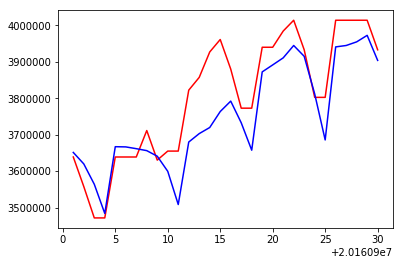

In [86]:
import matplotlib.pyplot as plt

best0 = pd.read_csv('./predict/score71.csv')
best = pd.read_csv('./predict/score73.csv')
prediction = pd.read_csv('./predict/Tianchi_power_predict_table.csv')

x = prediction['predict_date'].values

y0 = best0['predict_power_consumption'].values
y1 = best['predict_power_consumption'].values
y2 = prediction['predict_power_consumption'].values

# plt.plot(x, y0,'-go')
plt.plot(x, y1,'-r')
plt.plot(x, y2,'-b')
plt.show()